In [8]:
import numpy as np

def ridge_regression(X, y, lam):
    """
    Closed-form solution for ridge regression.
    
    Parameters:
    X   : (n, d) numpy array, input features
    y   : (n,) numpy array, target values
    lam : float, regularization parameter
    
    Returns:
    w : (d,) numpy array, weights
    b : float, bias
    """
    n, d = X.shape
    
    # Add bias term by appending a column of ones
    X_tilde = np.hstack([X, np.ones((n, 1))])
    
    # Construct regularization matrix (do not regularize bias term)
    reg = 2 * lam * np.eye(d + 1)
    reg[-1, -1] = 0  
    
    # Closed-form solution: (X^T X + reg)^(-1) X^T y
    A = X_tilde.T @ X_tilde + reg
    b_vec = X_tilde.T @ y
    w_tilde = np.linalg.solve(A, b_vec)
    
    w = w_tilde[:-1]
    b = w_tilde[-1]
    
    return w, b


In [9]:
# Example usage:
if __name__ == "__main__":
    np.random.seed(0)
    X = np.random.randn(100, 3)  # 100 samples, 3 features
    true_w = np.array([2.0, -1.0, 0.5])
    true_b = 1.0
    y = X @ true_w + true_b + 0.1 * np.random.randn(100)
    
    w, b = ridge_regression(X, y, lam=1.0)
    print("Estimated w:", w)
    print("Estimated b:", b)

Estimated w: [ 1.96042821 -0.98746093  0.49823092]
Estimated b: 0.9827461093396583


In [10]:
import numpy as np

def ridge_regression_gd(X, y, lam=1.0, eta=0.01, max_pass=1000, tol=1e-6):
    """
    Gradient descent for ridge regression.
    
    Parameters:
    X        : (n, d) numpy array, input features
    y        : (n,) numpy array, target values
    lam      : float, regularization parameter
    eta      : float, learning rate
    max_pass : int, maximum number of iterations
    tol      : float, tolerance for stopping criterion
    
    Returns:
    w : (d,) numpy array, weights
    b : float, bias
    losses : list, loss values during training
    """
    n, d = X.shape
    w = np.zeros(d)
    b = 0.0
    losses = []

    for t in range(max_pass):
        # Compute predictions
        y_pred = X @ w + b
        
        # Compute gradients
        grad_w = (1/n) * X.T @ (y_pred - y) + 2 * lam * w
        grad_b = (1/n) * np.sum(y_pred - y)
        
        # Update parameters
        w_new = w - eta * grad_w
        b_new = b - eta * grad_b
        
        # Compute loss
        loss = (1/(2*n)) * np.sum((y_pred - y)**2) + lam * np.sum(w**2)
        losses.append(loss)
        
        # Check convergence
        if np.linalg.norm(w_new - w) <= tol:
            w, b = w_new, b_new
            break
        
        w, b = w_new, b_new
    
    return w, b, losses

# Example usage:
if __name__ == "__main__":
    np.random.seed(0)
    X = np.random.randn(100, 3)  # 100 samples, 3 features
    true_w = np.array([2.0, -1.0, 0.5])
    true_b = 1.0
    y = X @ true_w + true_b + 0.1 * np.random.randn(100)
    
    w, b, losses = ridge_regression_gd(X, y, lam=1.0, eta=0.05, max_pass=5000)
    print("Estimated w:", w)
    print("Estimated b:", b)
    print("Final loss:", losses[-1])


Estimated w: [ 0.714581   -0.36144943  0.21582884]
Estimated b: 1.0062058867636674
Final loss: 1.9025318810001415


Raw CSV shapes:
X_train_df: (13, 306)
X_test_df: (13, 200)
y_train_df: (306, 1)
y_test_df: (200, 1)

After transpose:
X_train: (306, 13)
X_test: (200, 13)
y_train: (306,)
y_test: (200,)

After fixing sample count mismatch:
X_train: (306, 13)
X_test: (200, 13)
y_train: (306,)
y_test: (200,)

--- λ = 0 ---
Closed-form:
 Training Error: 9.69429863890932
 Training Loss : 4.84714931945466
 Test Error    : 370.222957298433
 Time          : 0.0016787052154541016 s
Gradient descent:
 Training Error: 9.694298642239923
 Training Loss : 4.847149321119962
 Test Error    : 370.1746584561936
 Time          : 0.022140026092529297 s

--- λ = 10 ---
Closed-form:
 Training Error: 9.998990986418427
 Training Loss : 423.87214861710424
 Test Error    : 203.76337250430012
 Time          : 7.224082946777344e-05 s
Gradient descent:
 Training Error: 275.8095210695737
 Training Loss : 140.9327385493702
 Test Error    : 126.98616331152276
 Time          : 0.0001800060272216797 s


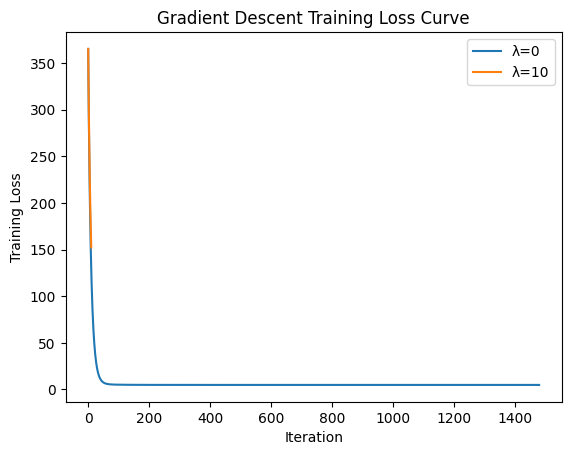

In [15]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# Standardization function
# ----------------------------
def standardize(train, test):
    mean = train.mean(axis=0)
    std = train.std(axis=0)
    std[std == 0] = 1.0  # Prevent division by zero
    train_std = (train - mean) / std
    test_std = (test - mean) / std
    return train_std, test_std

# ----------------------------
# Using functions from previous cells
# ----------------------------
# ridge_regression from Cell 1 (closed form)
# ridge_regression_gd from Cell 3 (gradient descent)

# ----------------------------
# Error & Loss
# ----------------------------
def compute_error(X, y, w, b):
    y_pred = X @ w + b
    return np.mean((y_pred - y)**2)

def compute_loss(X, y, w, b, lam):
    error = compute_error(X, y, w, b)
    return 0.5 * error + lam * np.sum(w**2)

# ----------------------------
# Main Experiment
# ----------------------------
# Load housing dataset from CSV files
# Load without headers first to check raw dimensions
X_train_df = pd.read_csv("./a1-files/housing_X_train.csv", header=None)
X_test_df = pd.read_csv("./a1-files/housing_X_test.csv", header=None)
y_train_df = pd.read_csv("./a1-files/housing_y_train.csv", header=None)
y_test_df = pd.read_csv("./a1-files/housing_y_test.csv", header=None)

print("Raw CSV shapes:")
print(f"X_train_df: {X_train_df.shape}")
print(f"X_test_df: {X_test_df.shape}")
print(f"y_train_df: {y_train_df.shape}")
print(f"y_test_df: {y_test_df.shape}")

# Convert to numpy and transpose
X_train = X_train_df.values.T
X_test = X_test_df.values.T
y_train = y_train_df.values.ravel()
y_test = y_test_df.values.ravel()

# Debug: Check shapes after transpose
print("\nAfter transpose:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Fix sample count mismatch
min_train_samples = min(X_train.shape[0], y_train.shape[0])
min_test_samples = min(X_test.shape[0], y_test.shape[0])

X_train = X_train[:min_train_samples, :]
y_train = y_train[:min_train_samples]
X_test = X_test[:min_test_samples, :]
y_test = y_test[:min_test_samples]

print(f"\nAfter fixing sample count mismatch:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Data is now properly aligned - both X and y have matching sample counts

# Standardize
X_train_std, X_test_std = standardize(X_train, X_test)

for lam in [0, 10]:
    print(f"\n--- λ = {lam} ---")
    
    # Closed form (using function from Cell 1)
    t0 = time.time()
    w_cf, b_cf = ridge_regression(X_train_std, y_train, lam)
    t_cf = time.time() - t0
    
    train_error_cf = compute_error(X_train_std, y_train, w_cf, b_cf)
    train_loss_cf = compute_loss(X_train_std, y_train, w_cf, b_cf, lam)
    test_error_cf = compute_error(X_test_std, y_test, w_cf, b_cf)
    
    print("Closed-form:")
    print(" Training Error:", train_error_cf)
    print(" Training Loss :", train_loss_cf)
    print(" Test Error    :", test_error_cf)
    print(" Time          :", t_cf, "s")
    
    # Gradient descent (using function from Cell 3)
    t0 = time.time()
    w_gd, b_gd, losses = ridge_regression_gd(X_train_std, y_train, lam=lam, eta=0.05, max_pass=5000)
    t_gd = time.time() - t0
    
    train_error_gd = compute_error(X_train_std, y_train, w_gd, b_gd)
    train_loss_gd = compute_loss(X_train_std, y_train, w_gd, b_gd, lam)
    test_error_gd = compute_error(X_test_std, y_test, w_gd, b_gd)
    
    print("Gradient descent:")
    print(" Training Error:", train_error_gd)
    print(" Training Loss :", train_loss_gd)
    print(" Test Error    :", test_error_gd)
    print(" Time          :", t_gd, "s")
    
    # Plot training loss curve
    plt.plot(losses, label=f"λ={lam}")
    plt.xlabel("Iteration")
    plt.ylabel("Training Loss")
    plt.title("Gradient Descent Training Loss Curve")
    plt.legend()

plt.show()
